<a href="https://colab.research.google.com/github/SupersuROOT/BabyGAN/blob/master/BabyGAN_(CHN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#![](https://raw.githubusercontent.com/tg-bomze/BabyGAN/master/media/logo.png)

<b><font color="black" size="+2">基于:</font></b>

**GitHub 存储库: [BabyGAN](https://github.com/tg-bomze/BabyGAN)**

*作者: [Denis Malimonov](https://github.com/tg-bomze)*

---
<b><font color="black" size="+1">使用:</font></b>

神经结构: **[StyleGAN](https://github.com/NVlabs/stylegan)** (*作者: [Tero Karras](https://research.nvidia.com/person/tero-karras), [Samuli Laine](https://research.nvidia.com/person/samuli-laine), [Timo Aila](https://research.nvidia.com/person/timo-aila)*)

编码器: **[stylegan-encoder](https://github.com/pbaylies/stylegan-encoder)** *(作者: [Peter Baylies](https://github.com/pbaylies), [Dmitry Nikitko](https://github.com/Puzer))*

---


```
To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```


In [2]:
!pip install 'h5py<3.0.0'
!pip install 'h5py<3.0.0'


In [15]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> 克隆项目并安装必要文件 </font></b>
%tensorflow_version 1.x

import os
import cv2
import math
import pickle
import imageio
import warnings
import PIL.Image
import numpy as np
from PIL import Image
import tensorflow as tf
from random import randrange
import moviepy.editor as mpy
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
%matplotlib inline
warnings.filterwarnings("ignore")

def get_watermarked(pil_image: Image) -> Image:
  try:
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    (h, w) = image.shape[:2]
    image = np.dstack([image, np.ones((h, w), dtype="uint8") * 255])
    pct = 0.08
    full_watermark = cv2.imread('/content/BabyGAN/media/logo.png', cv2.IMREAD_UNCHANGED)
    (fwH, fwW) = full_watermark.shape[:2]
    wH = int(pct * h*2)
    wW = int((wH * fwW) / fwH*0.1)
    watermark = cv2.resize(full_watermark, (wH, wW), interpolation=cv2.INTER_AREA)
    overlay = np.zeros((h, w, 4), dtype="uint8")
    (wH, wW) = watermark.shape[:2]
    overlay[h - wH - 10 : h - 10, 10 : 10 + wW] = watermark
    output = image.copy()
    cv2.addWeighted(overlay, 0.5, output, 1.0, 0, output)
    rgb_image = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb_image)
  except: return pil_image

def generate_final_images(latent_vector, direction, coeffs, i):
    new_latent_vector = latent_vector.copy()
    new_latent_vector[:8] = (latent_vector + coeffs*direction)[:8]
    new_latent_vector = new_latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(new_latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    if size[0] >= 512: img = get_watermarked(img)
    img_path = "/content/BabyGAN/for_animation/" + str(i) + ".png"
    img.thumbnail(animation_size, PIL.Image.ANTIALIAS)
    img.save(img_path)
    face_img.append(imageio.imread(img_path))
    clear_output()
    return img

def generate_final_image(latent_vector, direction, coeffs):
    new_latent_vector = latent_vector.copy()
    new_latent_vector[:8] = (latent_vector + coeffs*direction)[:8]
    new_latent_vector = new_latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(new_latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    if size[0] >= 512: img = get_watermarked(img)
    img.thumbnail(size, PIL.Image.ANTIALIAS)
    img.save("face.png")
    if 下载图像 == True: files.download("face.png")
    return img

def plot_three_images(imgB, fs = 10):
  f, axarr = plt.subplots(1,3, figsize=(fs,fs))
  axarr[0].imshow(Image.open('/content/BabyGAN/aligned_images/father_01.png'))
  axarr[0].title.set_text("Father's photo")
  axarr[1].imshow(imgB)
  axarr[1].title.set_text("Child's photo")
  axarr[2].imshow(Image.open('/content/BabyGAN/aligned_images/mother_01.png'))
  axarr[2].title.set_text("Mother's photo")
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

!rm -rf sample_data
!git clone https://github.com/SupersuROOT/BabyGAN.git
%cd /content/BabyGAN
!mkdir aligned_images data father_image mother_image

import config
import dnnlib
import dnnlib.tflib as tflib
from encoder.generator_model import Generator

age_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/age.npy')
horizontal_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/angle_horizontal.npy')
vertical_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/angle_vertical.npy')
eyes_open_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/eyes_open.npy')
gender_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/gender.npy')
smile_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/smile.npy')

clear_output()

In [4]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> 从Google Drive上获取模型 </font></b>
#@markdown **点击这个链接:**

#@markdown **https://drive.google.com/drive/folders/1xwqqG0HkLe2AiXxjC-XK8OfvMKT1jBlp**

#@markdown **1) 右键 “BabyGAN” (最上面)**

#@markdown **2) 选择 “Add shortcut to Drive”**

#@markdown ![](https://raw.githubusercontent.com/tg-bomze/BabyGAN/master/media/mount_eng.png)

#@markdown **3) 运行此单元格以继续**

#@markdown *注意！如果以前已运行过此单元格，请跳过！*

print("Follow the link below, select the account where you saved the pretrained model,")
print("click the 'Allow' button, copy authorization code in the field below and press Enter.")
drive.mount('/content/drive')
clear_output()
if os.path.isdir('/content/drive/My Drive/BabyGAN'):
  print("0%/100%   Copying has started")
  !cp '/content/drive/My Drive/BabyGAN/finetuned_resnet.h5' '/content/BabyGAN/data'
  !cp '/content/drive/My Drive/BabyGAN/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5' '/content/BabyGAN'
  print("50%/100%  Checkpoints copied")
  !cp '/content/drive/My Drive/BabyGAN/karras2019stylegan-ffhq-1024x1024.pkl' '/content/BabyGAN'
  !cp '/content/drive/My Drive/BabyGAN/vgg16_zhang_perceptual.pkl' '/content/BabyGAN'
  print("90%/100%  Weights copied")
  !cp '/content/drive/My Drive/BabyGAN/shape_predictor_68_face_landmarks.dat.bz2' '/content/BabyGAN'
  print("100%/100% Dictionary copied")
  clear_output()
  print("Done!")
else: raise ValueError('Please read the instructions in the block description and follow all 3 points correctly!')

Done!


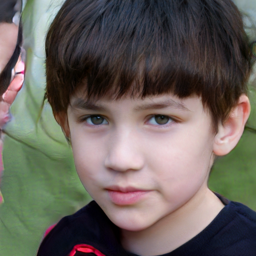

In [5]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> 上传父亲的图片</font></b>

!rm -rf /content/BabyGAN/father_image/*.*
#@markdown *上传图像或使用 url链接 (这需要您从电脑上上传图片并开启“允许第三方 cookies ”).*
url = '' #@param {type:"string"}
if url == '':
  uploaded = list(files.upload().keys())
  if len(uploaded) > 1: raise ValueError('You cannot upload more than one image at a time!')
  fat = uploaded[0]
else:
  try:
    !wget $url
    fat = url.split('/')[-1]
  except BaseException:
    print("Something wrong. Try uploading a photo from your computer")

FATHER_FILENAME = "father." + fat.split(".")[-1]
os.rename(fat, FATHER_FILENAME)
father_path = "/content/BabyGAN/father_image/" + FATHER_FILENAME
!mv -f $FATHER_FILENAME $father_path

!python align_images.py /content/BabyGAN/father_image /content/BabyGAN/aligned_images
clear_output()

if os.path.isfile('/content/BabyGAN/aligned_images/father_01.png'):
  pil_father = Image.open('/content/BabyGAN/aligned_images/father_01.png')
  (fat_width, fat_height) = pil_father.size
  resize_fat = max(fat_width, fat_height)/256
  display(pil_father.resize((int(fat_width/resize_fat), int(fat_height/resize_fat))))
else: raise ValueError('No face was found or there is more than one in the photo.')

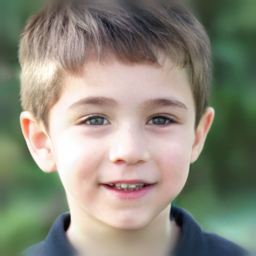

In [6]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> 上传母亲的图片</font></b>

!rm -rf /content/BabyGAN/mother_image/*.*
#@markdown *上传图像或使用 url链接 (这需要您从电脑上上传图片并开启“允许第三方 cookies ”).*
url = '' #@param {type:"string"}
if url == '':
  uploaded = list(files.upload().keys())
  if len(uploaded) > 1: raise ValueError('You cannot upload more than one image at a time!')
  mot = uploaded[0]
else:
  try:
    !wget $url
    mot = url.split('/')[-1]
  except BaseException:
    print("Something wrong. Try uploading a photo from your computer")

MOTHER_FILENAME = "mother." + mot.split(".")[-1]
os.rename(mot, MOTHER_FILENAME)
mother_path = "/content/BabyGAN/mother_image/" + MOTHER_FILENAME
!mv -f $MOTHER_FILENAME $mother_path

!python align_images.py /content/BabyGAN/mother_image /content/BabyGAN/aligned_images
clear_output()

if os.path.isfile('/content/BabyGAN/aligned_images/mother_01.png'):
  pil_mother = Image.open('/content/BabyGAN/aligned_images/mother_01.png')
  (mot_width, mot_height) = pil_mother.size
  resize_mot = max(mot_width, mot_height)/256
  display(pil_mother.resize((int(mot_width/resize_mot), int(mot_height/resize_mot))))
else: raise ValueError('No face was found or there is more than one in the photo.')

In [7]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> 获取潜在特征</font></b>
#@markdown *注意！这可能会需要3分钟的时间！*

'''
#use_pretraineg_model = True #@param {type:"boolean"}
if use_pretraineg_model == False:
  !rm finetuned_resnet.h5
  !python train_resnet.py \
  --test_size 256 \
  --batch_size 1024 \
  --loop 1 \
  --max_patience 1'''

#!python encode_images.py --help
!python encode_images.py \
  --early_stopping False \
  --lr=0.25 \
  --batch_size=2 \
  --iterations=100 \
  --output_video=False \
  /content/BabyGAN/aligned_images \
  /content/BabyGAN/generated_images \
  /content/BabyGAN/latent_representations

tflib.init_tf()
URL_FFHQ = "/content/BabyGAN/karras2019stylegan-ffhq-1024x1024.pkl"
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)
generator = Generator(Gs_network, batch_size=1, randomize_noise=False)
model_scale = int(2*(math.log(1024,2)-1))

clear_output()
if len(os.listdir('/content/BabyGAN/generated_images')) == 2:
  first_face = np.load('/content/BabyGAN/latent_representations/father_01.npy')
  second_face = np.load('/content/BabyGAN/latent_representations/mother_01.npy')
  print("Generation of latent representation is complete! Now comes the fun part.")
else: raise ValueError('Something wrong. It may be impossible to read the face in the photos. Upload other photos and try again.')

Generation of latent representation is complete! Now comes the fun part.




---



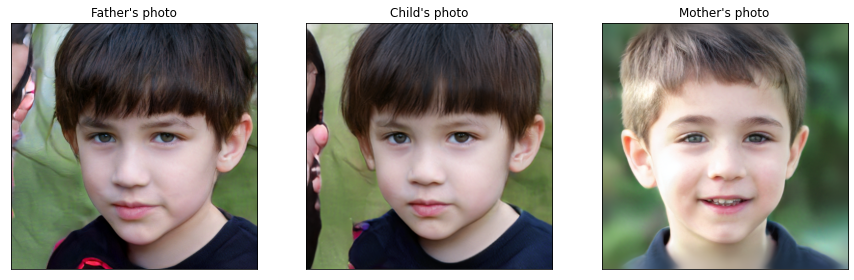

In [24]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> 生成孩子照片</font></b> { run: "auto", display-mode: "form" }
#@markdown **双方基因占比**

#@markdown *越接近 0，父亲的基因影响越大，反之亦然*
基因影响 = 0.01 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
#@markdown **设置图片样式**
风格 = "\u9ED8\u8BA4" #@param ["默认", "父亲的照片", "母亲的照片"]
if 风格 == "父亲的照片": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**基因影响).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (lr*first_face) + (rl*second_face)
elif 风格 == "母亲的照片": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**(1-基因影响)).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (rl*first_face) + (lr*second_face)
else: hybrid_face = ((1-基因影响)*first_face)+(基因影响*second_face)
#@markdown **孩子的大致年龄:**
年龄 = 24 #@param {type:"slider", min:10, max:50, step:1}
intensity = -((年龄/5)-6)
#@markdown ---
#@markdown **是否下载图像？**
下载图像 = False #@param {type:"boolean"}
#@markdown **下载的图像分辨率:**
分辨率 = "256" #@param [256, 512, 1024]
size = int(分辨率), int(分辨率)

face = generate_final_image(hybrid_face, age_direction, intensity)
plot_three_images(face, fs = 15)

In [26]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> 生成孩子的性别渐变视频</font></b> { display-mode: "form" }
!rm -rf /content/BabyGAN/for_animation
!mkdir /content/BabyGAN/for_animation
face_img = []

#@markdown **孩子的大致年龄:**
年龄 = 24 #@param {type:"slider", min:10, max:50, step:1}
intensity = -((年龄/5)-6)
#@markdown **视频分辨率:**
视频分辨率 = "1024" #@param [256, 512, 1024]
animation_size = int(视频分辨率), int(视频分辨率)
#@markdown **帧数:**

#@markdown *数值越大，视频的过度就更平滑.*
帧数 = 50 #@param {type:"slider", min:10, max:50, step:1}

for i in range(1, 帧数):
  gender_influence = i/帧数
  hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
  face = generate_final_images(hybrid_face, age_direction, intensity, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(帧数)))

for j in reversed(face_img):
  face_img.append(j)

#@markdown ---
#@markdown **是否下载视频？**
下载视频 = False #@param {type:"boolean"}
#@markdown *若未选中，则在下方播放视频.*

animation_name = str(年龄) + "_years.mp4"

imageio.mimsave('/content/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

if 下载视频 == True: 
  files.download('/content/BabyGAN/for_animation/'+animation_name)
display(mpy.ipython_display('/content/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

In [27]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> 生成孩子的年龄渐变视频</font></b> { display-mode: "form" }
!rm -rf for_animation
!mkdir for_animation
face_img = []

#@markdown **双方基因占比:**

#@markdown *越接近 0，父亲的基因影响越大，反之亦然.*
基因影响 = 0.01 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
hybrid_face = ((1-基因影响)*first_face)+(基因影响*second_face)
#@markdown **视频分辨率:**
视频分辨率 = "512" #@param [256, 512, 1024]
animation_size = int(视频分辨率), int(视频分辨率)
#@markdown **帧数:**

#@markdown *数值越大，视频的过度就更平滑.*
帧数 = 50 #@param {type:"slider", min:10, max:50, step:1}
for i in range(0, 帧数, 1):
  intensity = (8*(i/(帧数-1)))-4
  generate_final_images(hybrid_face, age_direction, intensity, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(帧数)))

for j in reversed(face_img):
  face_img.append(j)

#@markdown ---
#@markdown **是否下载视频？**
下载视频 = False #@param {type:"boolean"}
#@markdown *若未选中，则在下方播放视频.*

if gender_influence <= 0.3:
  animation_name = "boy.mp4"
elif gender_influence >= 0.7:
  animation_name = "girl.mp4"
else:
  animation_name = "animation.mp4"

imageio.mimsave('/content/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

if 下载视频 == True:
  files.download('/content/BabyGAN/for_animation/'+animation_name)
display(mpy.ipython_display('/content/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

## **附加功能** *(面部修饰)*

*____* *↓ 单击以打开 ↓* *____*

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

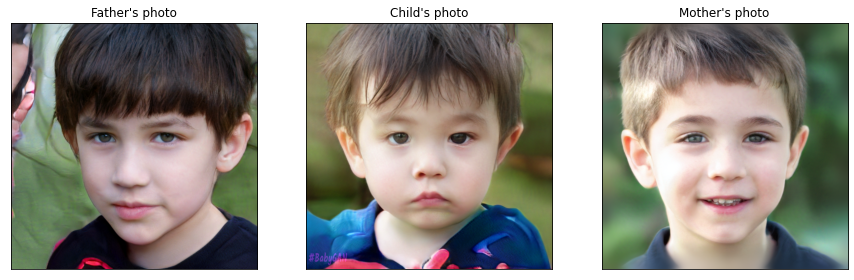

In [28]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> 更改孩子的脸部参数</font></b> { run: "auto", display-mode: "form" }
#@markdown **基因占比:**

#@markdown *越接近 0，父亲的基因影响越大，反之亦然.*
基因影响 = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
#@markdown **设置图片样式:**
风格 = "默认" #@param ["默认", "父亲的照片", "母亲的照片"]
if 风格 == "父亲的照片": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**基因影响).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (lr*first_face) + (rl*second_face)
elif 风格 == "母亲的照片": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**(1-基因影响)).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (rl*first_face) + (lr*second_face)
else: hybrid_face = ((1-基因影响)*first_face)+(基因影响*second_face)

#@markdown **选择强度:**
水平 = 13 #@param {type:"slider", min:-100, max:100, step:1}
horizontal_intensity = 水平/50
垂直 = 0 #@param {type:"slider", min:-100, max:100, step:1}
vertical_intensity = 垂直/50
睁开眼睛 = -14 #@param {type:"slider", min:-100, max:100, step:1}
eyes_open_intensity = -(睁开眼睛/25)
性别 = 0 #@param {type:"slider", min:-100, max:100, step:1}
gender_intensity = 性别/100
微笑 = -100 #@param {type:"slider", min:-100, max:100, step:1}
smile_intensity = 微笑/100
年龄 = -100 #@param {type:"slider", min:-100, max:100, step:1}
age_intensity = -(年龄/25)

direction_intensity = (horizontal_direction*horizontal_intensity) + (vertical_direction*vertical_intensity) + (eyes_open_direction*eyes_open_intensity) + (gender_direction*gender_intensity) + (smile_direction*smile_intensity) + (age_direction*age_intensity)

#@markdown ---
#@markdown **是否下载图像？**
下载图像 = True #@param {type:"boolean"}
#@markdown **图像分辨率:**
分辨率 = "512" #@param [256, 512, 1024]
size = int(分辨率), int(分辨率)

face = generate_final_image(hybrid_face, direction_intensity, 1)
plot_three_images(face, fs = 15)

In [29]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generating animation for smooth change of the selected option</font></b> {display-mode: "form" }
!rm -rf for_animation
!mkdir for_animation
face_img = []

#@markdown **基因占比:**
基因影响 = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
hybrid_face = ((1-基因影响)*first_face)+(基因影响*second_face)
#@markdown **视频分辨率:**
分辨率 = "512" #@param [256, 512, 1024]
animation_size = int(分辨率), int(分辨率)

#@markdown **帧数:**
帧数 = 50 #@param {type:"slider", min:9, max:50, step:1}
#@markdown **视频选项:**
for i in range(0, 帧数, 1):
  intensity = (100*(i/(帧数-1)))-50
  
  horizontal_intensity = intensity/25
  vertical_intensity = intensity/25
  eyes_open_intensity = -(intensity/12.5)
  gender_intensity = intensity/50
  smile_intensity = intensity/50
  age_intensity = -(intensity/12.5)

  水平 = horizontal_direction * horizontal_intensity
  垂直 = vertical_direction * vertical_intensity
  睁开眼睛 = eyes_open_direction * eyes_open_intensity
  性别 = gender_direction * gender_intensity
  微笑 = smile_direction * smile_intensity
  年龄 = age_direction * age_intensity

  选项 = 水平 #@param ["水平", "垂直", "睁开眼睛", "性别", "微笑", "年龄"] {type:"raw"}

  generate_final_images(hybrid_face, 选项, 1, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(帧数)))

for j in reversed(face_img):
  face_img.append(j)

#@markdown ---
#@markdown **是否下载视频？**
下载视频 = False #@param {type:"boolean"}

if gender_influence <= 0.3:
  animation_name = "boy.mp4"
elif gender_influence >= 0.7:
  animation_name = "girl.mp4"
else:
  animation_name = "animation.mp4"

imageio.mimsave('/content/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

if 下载视频 == True:
  files.download('/content/BabyGAN/for_animation/'+animation_name)
display(mpy.ipython_display('/content/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

In [30]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> 更改3个参数以来生成孩子的视频</font></b> { display-mode: "form" }
!rm -rf for_animation
!mkdir for_animation
face_img = []

#@markdown **基因占比:**
基因影响 = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
hybrid_face = ((1-基因影响)*first_face)+(基因影响*second_face)
#@markdown **视频分辨率:**
分辨率 = "256" #@param [256, 512, 1024]
animation_size = int(分辨率), int(分辨率)
#@markdown **帧数:**
帧数 = 50 #@param {type:"slider", min:10, max:100, step:1}

#@markdown **第一个参数:**
参数一 = '\u5E74\u9F84' #@param ["年龄", "水平", "垂直", "睁开眼睛", "性别", "微笑"]
direction_file1 = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/' + 参数一 + '.npy')
一号强度 = 0.5 #@param {type:"slider", min:-5, max:5, step:0.05}
if 一号强度 == 0: 一号强度 += 0.001
coeffs1 = []
for i in range(0, 帧数):
  coeffs1.append(round((i*一号强度)/帧数,3))


#@markdown **第二个参数:**
参数二 = '\u5782\u76F4' #@param ["年龄", "水平", "垂直", "睁开眼睛", "性别", "微笑"]
direction_file2 = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/' + 参数二 + '.npy')
二号强度 = 5 #@param {type:"slider", min:-5, max:5, step:0.05}
if 二号强度 == 0: 二号强度 += 0.001
coeffs2 = []
for i in range(0, 帧数):
  coeffs2.append(round((i*二号强度)/帧数,3))

#@markdown **第三个参数:**
参数三 = '微笑' #@param ["年龄", "水平", "垂直", "睁开眼睛", "性别", "微笑"]
direction_file3 = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/' + 参数三 + '.npy')
三号强度 = 1 #@param {type:"slider", min:-5, max:5, step:0.05}
if 三号强度 == 0: 三号强度 += 0.001
coeffs3 = []
for i in range(0, 帧数):
  coeffs3.append(round((i*三号强度)/帧数,3))

for i in range(帧数):
  direction_intensity1 = direction_file1 * coeffs1[i]
  direction_intensity2 = direction_file2 * coeffs2[i]
  direction_intensity3 = direction_file3 * coeffs3[i]
  direction_intensity = direction_intensity1 + direction_intensity2 + direction_intensity3
  generate_final_images(hybrid_face, direction_intensity, 1, i)
  clear_output()
  print('Generated ' + str(i) + ' photos of ' + str(帧数))

add_invert = True
img = os.listdir("for_animation")
img.sort()
clear_output()
print('The animation is being generated. Please wait.')

for j in reversed(face_img):
  face_img.append(j)
face_img = np.array(face_img)
imageio.mimsave("/content/BabyGAN/for_animation/3param.mp4", face_img)
clear_output()

#@markdown ---
#@markdown **是否下载视频？**
下载视频 = False #@param {type:"boolean"}
if 下载视频 == True:
  files.download("/content/BabyGAN/for_animation/3param.mp4")
display(mpy.ipython_display("/content/BabyGAN/for_animation/3param.mp4", height=400, autoplay=1, loop=1))